In [16]:
import Pkg
Pkg.add("Measures")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Measures ─ v0.3.3
    Updating `~/.julia/environments/v1.10/Project.toml`
  [442fdcdd] + Measures v0.3.3
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [442fdcdd] ↑ Measures v0.3.2 ⇒ v0.3.3
Precompiling project...


In [17]:
using Random, Statistics
using Plots, Distributions
using Measures

# -----------------------------
# Model: W lanes, each lane is a stack of capacity L.
# Cargo item is just its destination port (Int).
# Shift = relocating a blocking item to another lane.
# -----------------------------

struct Deck
    lanes::Vector{Vector{Int}}  # each lane is a stack; end is "top"
    L::Int
end

Deck(W::Int, L::Int) = Deck([Int[] for _ in 1:W], L)

capacity_left(d::Deck, lane::Int) = d.L - length(d.lanes[lane])

function push_cargo!(d::Deck, lane::Int, dest::Int)
    if length(d.lanes[lane]) >= d.L
        return false
    end
    Base.push!(d.lanes[lane], dest)
    return true
end

function pop_cargo!(d::Deck, lane::Int)
    isempty(d.lanes[lane]) && return nothing
    return Base.pop!(d.lanes[lane])
end

# Find a lane (not `exclude_lane`) that has space, using a simple tie-break:
# choose the lane with most free capacity.
function find_relocation_lane(d::Deck; exclude_lane::Int)
    best = 0
    best_free = -1
    for j in 1:length(d.lanes)
        j == exclude_lane && continue
        free = capacity_left(d, j)
        if free > best_free
            best_free = free
            best = j
        end
    end
    return best_free > 0 ? best : 0
end

# -----------------------------
# Unloading simulation
# For each destination port p in 2..P:
# keep removing items with dest p; if blocked, shift blocking tops elsewhere.
# -----------------------------
function unload_all!(d::Deck, P::Int)
    shifts = 0

    for p in 2:P
        # Keep going until no cargo with destination p remains
        while true
            # Find a lane that contains p somewhere
            lane_with_p = 0
            for i in 1:length(d.lanes)
                if any(x -> x == p, d.lanes[i])
                    lane_with_p = i
                    break
                end
            end
            lane_with_p == 0 && break  # no more cargo for port p

            # Now try to unload p from this lane by shifting blockers on top
            while true
                top = isempty(d.lanes[lane_with_p]) ? nothing : d.lanes[lane_with_p][end]
                if top === nothing
                    # shouldn't happen because we found p in the lane
                    return (false, shifts)
                elseif top == p
                    pop_cargo!(d, lane_with_p)  # unload (not a shift)
                    break
                else
                    # need to shift blocker
                    target = find_relocation_lane(d; exclude_lane=lane_with_p)
                    target == 0 && return (false, shifts) # no space to shift -> infeasible
                    blocker = pop_cargo!(d, lane_with_p)
                    push_cargo!(d, target, blocker)
                    shifts += 1
                end
            end
        end
    end

    return (true, shifts)
end

# -----------------------------
# Heuristic 1: "Symmetric" lane assignment
# Map destination ports to lanes in a symmetric pattern.
# Example: with W lanes, assign ports alternately left-right from center.
# Then load items in arbitrary order into that lane if possible; if full, spill to next lane.
# -----------------------------
function symmetric_lane_map(W::Int, dest_ports::Vector{Int})
    center = (W + 1) ÷ 2
    order = Int[]

    # These must be Base.push! because order is a Vector, not a Deck
    Base.push!(order, center)

    for k in 1:W
        left = center - k
        right = center + k
        if left >= 1
            Base.push!(order, left)
        end
        if right <= W
            Base.push!(order, right)
        end
        length(order) >= W && break
    end

    m = Dict{Int,Int}()
    for (idx, p) in enumerate(dest_ports)
        m[p] = order[1 + (idx - 1) % W]
    end
    return m
end

function load_symmetric!(d::Deck, cargo::Vector{Int}, P::Int)
    dest_ports = collect(2:P)
    lane_map = symmetric_lane_map(length(d.lanes), dest_ports)

    for dest in cargo
        preferred = lane_map[dest]
        placed = false
        # try preferred lane first, then others in increasing distance
        for offset in 0:(length(d.lanes)-1)
            lane = 1 + ((preferred - 1 + offset) % length(d.lanes))
            if push_cargo!(d, lane, dest)
                placed = true
                break
            end
        end
        placed || return false
    end
    return true
end

# -----------------------------
# Heuristic 2: Simple greedy
# Idea: load later-destination cargo first (so it sits deeper),
# and place each item into the lane where it "best fits":
# choose lane with most free space (keeps room for future spillovers).
# -----------------------------
function load_greedy!(d::Deck, cargo::Vector{Int})
    # later ports first => deeper in stacks
    sorted = sort(cargo; rev=true)

    for dest in sorted
        best_lane = 0
        best_free = -1
        for lane in 1:length(d.lanes)
            free = capacity_left(d, lane)
            if free > best_free
                best_free = free
                best_lane = lane
            end
        end
        best_free <= 0 && return false
        push_cargo!(d, best_lane, dest)
    end
    return true
end


load_greedy! (generic function with 1 method)

In [18]:
using Printf
function pretty_print_results(out)
    println("\n=== Monte Carlo summary ===")
    println(rpad("Heuristic", 12), rpad("Feasible", 10), rpad("Mean shifts", 14), rpad("Std", 10), "N(feasible)")
    println("-"^58)

    for h in (:symmetric, :greedy)
        fr = out.feasible_rate[h]
        st = out.shift_stats[h]
        mean_sh = st.mean
        std_sh  = st.std
        nfeas   = st.n

        println(rpad(string(h), 12),
                rpad(@sprintf("%.3f", fr), 10),
                rpad(isfinite(mean_sh) ? @sprintf("%.3f", mean_sh) : "NA", 14),
                rpad(isfinite(std_sh)  ? @sprintf("%.3f", std_sh)  : "NA", 10),
                nfeas)
    end
    println()
end


pretty_print_results (generic function with 1 method)

In [19]:
function plot_feasible_rates(out)
    hs = [:symmetric, :greedy]
    rates = [out.feasible_rate[h] for h in hs]
    bar(string.(hs), rates,
        ylim=(0,1),
        xlabel="Heuristic",         
        ylabel="Feasible rate",
        title="Feasible rate by heuristic",
        legend=false,
        left_margin=8mm,             
        bottom_margin=8mm)           
end


plot_feasible_rates (generic function with 1 method)

In [20]:
function plot_shift_histograms(out; bins=:auto)
    # If you returned raw samples as out.shift_samples, use that.
    # If not, see small change to mc_experiment below.

    hs = [:symmetric, :greedy]
    plt = plot(layout=(1,2), size=(900,350), titlefont=10)

    for (k,h) in enumerate(hs)
        samples = out.shift_samples[h]
        histogram!(plt[k], samples,
            bins=bins,
            title="Shifts: $(h)",
            xlabel="Number of shifts",
            ylabel="Count",
            legend=false,
            left_margin=8mm,
            bottom_margin=8mm)
    end
    return plt
end

plot_shift_histograms (generic function with 1 method)

In [21]:
# -----------------------------
# Monte Carlo experiment
# -----------------------------
function mc_experiment(; trials=2000, seed=1, W=4, L=5, P=5, N=18, dest_probs=nothing)
    rng = MersenneTwister(seed)

    # probabilities for destinations 2..P
    if dest_probs === nothing
        dest_probs = fill(1.0/(P-1), P-1)
    end
    @assert length(dest_probs) == P-1
    # cumulative for sampling
    cdf = cumsum(dest_probs)

    function sample_dest()
        u = rand(rng)
        k = searchsortedfirst(cdf, u) # 1..P-1
        return 1 + k  # maps to 2..P
    end

    function run_one(loadfn)
        d = Deck(W, L)
        cargo = [sample_dest() for _ in 1:N]
        ok_load = loadfn(d, cargo)
        ok_load || return (false, Inf)
        ok_unload, shifts = unload_all!(d, P)
        return (ok_unload, shifts)
    end

    # wrappers for load functions (so signatures match)
    sym_load = (d, cargo) -> load_symmetric!(d, cargo, P)
    grd_load = (d, cargo) -> load_greedy!(d, cargo)

    results = Dict(
        :symmetric => Int[],
        :greedy    => Int[]
    )
    feasible = Dict(
        :symmetric => 0,
        :greedy    => 0
    )

    for _ in 1:trials
        ok, sh = run_one(sym_load)
        if ok
            feasible[:symmetric] += 1
            Base.push!(results[:symmetric], sh)
        end

        ok, sh = run_one(grd_load)
        if ok
            feasible[:greedy] += 1
            Base.push!(results[:greedy], sh)
        end
    end

    function summarize(vec)
        isempty(vec) && return (mean=Inf, std=Inf, n=0)
        return (mean=mean(vec), std=std(vec), n=length(vec))
    end

    return (
    feasible_rate = Dict(
        :symmetric => feasible[:symmetric] / trials,
        :greedy    => feasible[:greedy] / trials
    ),
    shift_stats = Dict(
        :symmetric => summarize(results[:symmetric]),
        :greedy    => summarize(results[:greedy])
    ),
    shift_samples = results  # <-- add this
    )
end

mc_experiment (generic function with 1 method)


=== Monte Carlo summary ===
Heuristic   Feasible  Mean shifts   Std       N(feasible)
----------------------------------------------------------
symmetric   0.863     1.501         1.533     1725
greedy      1.000     0.000         0.000     2000



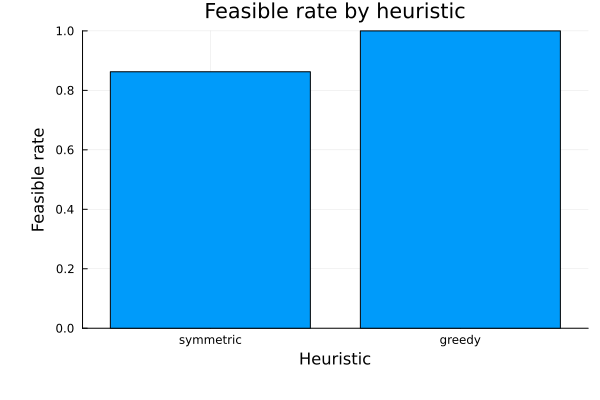

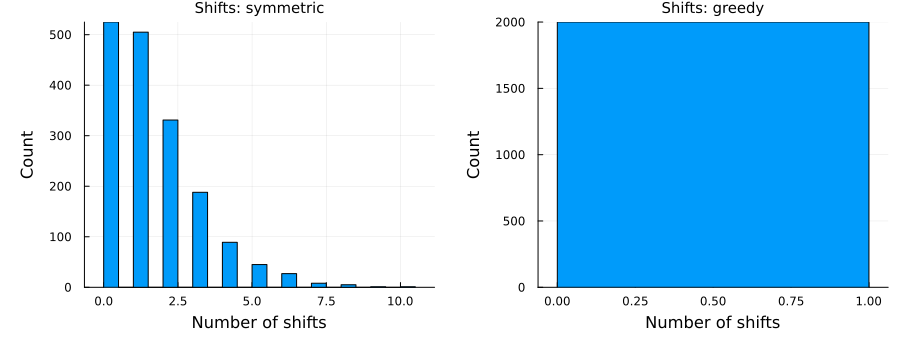

In [22]:
out = mc_experiment(trials=2000, seed=42, W=4, L=5, P=5, N=18)

pretty_print_results(out)
display(plot_feasible_rates(out))
display(plot_shift_histograms(out))